Para la Clorofila

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

In [2]:
import rasterio
import rasterio.plot as rioplot

In [3]:
import datetime
from pyproj import CRS
import xarray as xr
import rioxarray
import regionmask as rm
import shapefile 

In [4]:
datos_ruta = Path("~/shared/proyecto5")

In [5]:
ecoregiones_gdf = gpd.read_file(datos_ruta / "MEOW" / "meow_ecos.shp")

Seleccionamos la ecoregio

In [6]:
def seleccion_ecoregion(gdf, ecoregion):
    sel_gdf = gdf[gdf["ECOREGION"] == ecoregion]
    sel_bordes_df = sel_gdf.geometry.bounds
    sel_bordes = dict(
        minx=sel_bordes_df.minx.values[0],
        maxx=sel_bordes_df.maxx.values[0],
        miny=sel_bordes_df.miny.values[0],
        maxy=sel_bordes_df.maxy.values[0],
    )
    return sel_gdf, sel_bordes

In [7]:
ecoregion_gdf, ecoregion_bordes = seleccion_ecoregion(ecoregiones_gdf, "Southern California Bight")

In [8]:
ecoregion_bordes

{'minx': -122.78361441614561,
 'maxx': -113.5026238882092,
 'miny': 24.142766583670152,
 'maxy': 36.885469959754005}

Leer los datos ERDDAP

In [12]:
erddap_opendap_url = 'https://coastwatch.pfeg.noaa.gov/erddap/es/griddap/erdMH1chlamday_R2022SQ'

fuente_ds = xr.open_dataset(erddap_opendap_url)

In [13]:
fuente_ds

<xarray.Dataset>
Dimensions:    (time: 246, latitude: 4320, longitude: 8640)
Coordinates:
  * time       (time) datetime64[ns] 2002-07-16 2002-08-16 ... 2022-12-16
  * latitude   (latitude) float32 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    chlor_a    (time, latitude, longitude) float32 ...
Attributes: (12/52)
    _lastModified:                     2023-03-02T00:12:58.000Z
    cdm_data_type:                     Grid
    Conventions:                       CF-1.6 ACDD-1.3, COARDS
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    creator_type:                      group
    ...                                ...
    summary:                           Moderate Resolution Imaging Spectrorad...
    temporal_range:                    month
    time_coverage_end:                 2022-12-16T00:00:00Z
    time_coverage_start:               2002-07-16T00:00:00Z
    title:                             Chlorophyll-a, Aqua MODIS, NPP, L3SMI,...
    Westernmost_Easting:               -179.9792

In [14]:
print(f"Tamaño del dataset: {fuente_ds.nbytes/1e6}MB")

Tamaño del dataset: 36727.657008MB


Definir subset del dataset de SST

In [15]:
año_inicio = 2014
año_final= 2015

In [16]:
subset_fuente_ds = fuente_ds.sel(
    time=slice(datetime.datetime(año_inicio,1,1), datetime.datetime(año_final,12,31)), 
    latitude=slice(ecoregion_bordes['maxy'], ecoregion_bordes['miny']),
    longitude=slice(ecoregion_bordes['minx'], ecoregion_bordes['maxx'])
)

In [17]:
subset_fuente_ds

<xarray.Dataset>
Dimensions:    (time: 24, latitude: 306, longitude: 223)
Coordinates:
  * time       (time) datetime64[ns] 2014-01-16 2014-02-16 ... 2015-12-16
  * latitude   (latitude) float32 36.85 36.81 36.77 36.73 ... 24.23 24.19 24.15
  * longitude  (longitude) float32 -122.8 -122.7 -122.7 ... -113.6 -113.6 -113.5
Data variables:
    chlor_a    (time, latitude, longitude) float32 ...
Attributes: (12/52)
    _lastModified:                     2023-03-02T00:12:58.000Z
    cdm_data_type:                     Grid
    Conventions:                       CF-1.6 ACDD-1.3, COARDS
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    creator_type:                      group
    ...                                ...
    summary:                           Moderate Resolution Imaging Spectrorad...
    temporal_range:                    month
    time_coverage_end:                 2022-12-16T00:00:00Z
    time_coverage_start:               2002-07-16T00:00:00Z
    title:                             Chlorophyll-a, Aqua MODIS, NPP, L3SMI,...
    Westernmost_Easting:               -179.9792

In [18]:
print(f"Tamaño del dataset: {subset_fuente_ds.nbytes/1e6} MB")

Tamaño del dataset: 6.553156 MB


Descargar los datos al dataset de xarray

In [19]:
%%time
subset_fuente_ds.load();

CPU times: user 138 ms, sys: 96.1 ms, total: 234 ms
Wall time: 6min 31s


Exploramos los datos

In [20]:
subset_fuente_ds

<xarray.Dataset>
Dimensions:    (time: 24, latitude: 306, longitude: 223)
Coordinates:
  * time       (time) datetime64[ns] 2014-01-16 2014-02-16 ... 2015-12-16
  * latitude   (latitude) float32 36.85 36.81 36.77 36.73 ... 24.23 24.19 24.15
  * longitude  (longitude) float32 -122.8 -122.7 -122.7 ... -113.6 -113.6 -113.5
Data variables:
    chlor_a    (time, latitude, longitude) float32 1.031 1.03 ... 0.1621 0.166
Attributes: (12/52)
    _lastModified:                     2023-03-02T00:12:58.000Z
    cdm_data_type:                     Grid
    Conventions:                       CF-1.6 ACDD-1.3, COARDS
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    creator_type:                      group
    ...                                ...
    summary:                           Moderate Resolution Imaging Spectrorad...
    temporal_range:                    month
    time_coverage_end:                 2022-12-16T00:00:00Z
    time_coverage_start:               2002-07-16T00:00:00Z
    title:                             Chlorophyll-a, Aqua MODIS, NPP, L3SMI,...
    Westernmost_Easting:               -179.9792

In [24]:
import numpy as np

In [86]:
#subset_fuente_ds["chlor_a"]=np.log(subset_fuente_ds.chlor_a)

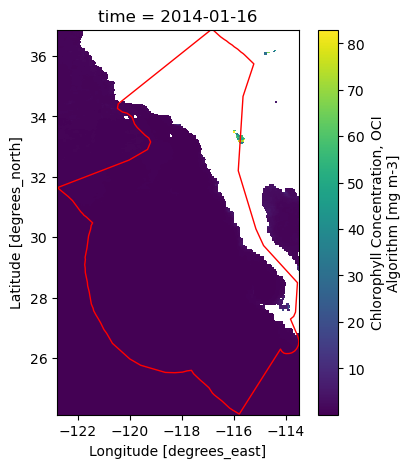

In [21]:
_, ax = plt.subplots(ncols=1, figsize=(5,5))
subset_fuente_ds.chlor_a.isel(time=0).plot(ax=ax), 
ecoregion_gdf.plot(ax=ax, edgecolor='red', facecolor='none');

Este mapa aun no tiene incluida la mascara de la ecoregion, pero puede servir para comparar 
lo que esta pasando dentro y fuera de la ecoregion, es decir que se pueden contrastar
aunque en este caso el Golfo de California no tiene mucha variacion el mes de enero del 2014, 
pero tambien puede ser por el efecto de la visualizacion en sus valores digitales originales 
por eso se ve todo del mismo color 

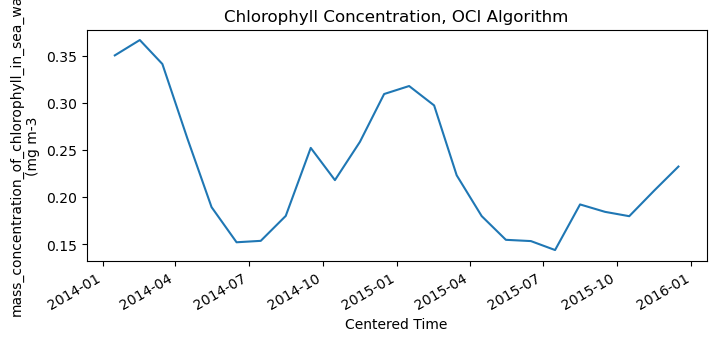

In [23]:
da = subset_fuente_ds.chlor_a

sst_xypromedio_df.plot(figsize=(8,3))
plt.ylabel(f"{da.standard_name}\n({da.units}")
plt.title(da.long_name);